In [1]:
import pandas as pd
import numpy as np
import ripser
import matplotlib.pyplot as plt
import umap
import math
import networkx as nx
import gudhi as gd
from gtda.mapper import CubicalCover, make_mapper_pipeline, Projection, plot_static_mapper_graph
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import connected_components
from matplotlib.cm import get_cmap
# Data viz
from gtda.plotting import plot_point_cloud
import matplotlib.patches as mpatches
np.random.seed(42)

def calculate_diameter(xyz_points):
    """Calculate the diameter of a 3D dataset (the largest distance between any two points)."""
    distances = pdist(xyz_points)
    max_distance = np.max(distances)
    L = round(max_distance)
    return L

def calculate_partitions(L, epsilon, alpha):
    """Calculate the number of partitions (N) for a given set length (L), partition length (epsilon), and overlap percentage (alpha)."""
    shift = epsilon * (1 - alpha / 100)
    N = math.floor((L - epsilon) / shift) + 1
    return N

def find_connected_components(data, R):
    """
    Finds connected components in the Vietoris-Rips complex.
    """
    from scipy.sparse.csgraph import connected_components
    from scipy.spatial.distance import pdist, squareform

    # Compute pairwise distances
    dist_matrix = squareform(pdist(data))

    # Create adjacency matrix
    adjacency_matrix = (dist_matrix <= R).astype(int)

    # Find connected components
    n_components, labels = connected_components(adjacency_matrix, directed=False)
    components = [data[labels == i] for i in range(n_components)]

    return components

# Define the functions (unchanged)
def plot_vietoris_rips_complex(data, R, label="data", col=1, maxdim=2):
    """
    Plots the Vietoris-Rips complex for a given set of points.
    """
    tab10 = get_cmap('tab10')  # Colormap for points
    viridis = get_cmap('viridis')  # Colormap for triangles

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(f"Vietoris-Rips Complex (R = {R})")

    # Plot points with smaller size
    ax.scatter(
        data[:, 0], data[:, 1], label=label,
        s=20, alpha=0.9, c=np.array([tab10(col)] * len(data))  # Smaller dot size
    )

    # Step 1: Add lighter circles for each point
    for xy in data:
        ax.add_patch(mpatches.Circle(
            xy, radius=R, fill=False,
            edgecolor=tab10(col), alpha=0.1, linestyle='dotted'  # Lighter circles
        ))

    # Step 2: Draw edges (1-simplices)
    for i, xy in enumerate(data):
        for j in range(i + 1, len(data)):
            pq = data[j]
            if np.linalg.norm(xy - pq) <= R:
                ax.plot(
                    [xy[0], pq[0]], [xy[1], pq[1]],
                    color=tab10(col), alpha=0.6, linewidth=1
                )

    # Step 3: Draw triangles (2-simplices) if maxdim >= 2
    if maxdim >= 2:
        triangle_index = 0  # Index for assigning colors
        for i, xy in enumerate(data):
            for j in range(i + 1, len(data)):
                pq = data[j]
                if np.linalg.norm(xy - pq) <= R:
                    for k in range(j + 1, len(data)):
                        ab = data[k]
                        if (np.linalg.norm(xy - ab) <= R and
                            np.linalg.norm(pq - ab) <= R):
                            # All edges are within the threshold R
                            triangle = np.array([xy, pq, ab])
                            color = viridis(triangle_index / len(data))  # Unique color
                            ax.fill(
                                triangle[:, 0], triangle[:, 1],
                                color=color, alpha=0.5  # Adjust alpha for transparency
                            )
                            triangle_index += 1  # Update index for next triangle

    ax.axis('equal')
    plt.tight_layout()
    plt.show()

    # Find and return connected components
    components = find_connected_components(data, R)
    return components


def calculate_epsilon_for_betti_value_gd(persistence, resolution=1000):
    """
    Calculate the epsilon (threshold) at which Betti-1 reaches its maximum value.
    """
    x_values, betti_0, betti_1 = calculate_betti_curves_gd(persistence, resolution=resolution)
    
    # Find the index where Betti-1 is maximum using NumPy
    max_betti_1_index = np.argmax(betti_1)
    
    # Get the corresponding epsilon value
    epsilon_at_max_betti_1 = x_values[max_betti_1_index]
    
    return epsilon_at_max_betti_1, betti_1[max_betti_1_index]

def calculate_betti_curves(persistence_diagrams, resolution=1000):
    """
    Calculate Betti curves from a persistence diagram returned by ripser.

    Parameters:
        persistence_diagrams (list of arrays): Persistence diagrams from ripser.
        resolution (int): Number of points to evaluate the Betti curves.

    Returns:
        x_values (array): Threshold values.
        betti_0 (array): Betti-0 curve.
        betti_1 (array): Betti-1 curve.
    """
    # Extract H0 and H1 persistence diagrams
    dim_0_points = persistence_diagrams[0]  # H0 (connected components)
    dim_1_points = persistence_diagrams[1]  # H1 (loops)

    # Remove infinite death values for H0
    dim_0_points = dim_0_points[~np.isinf(dim_0_points[:, 1])]

    # Combine all finite values to determine the range for the x-axis
    all_finite_values = np.concatenate([dim_0_points.flatten(), dim_1_points.flatten()])
    all_finite_values = all_finite_values[~np.isinf(all_finite_values)]  # Remove infinities
    min_val = np.min(all_finite_values)
    max_val = np.max(all_finite_values)

    # Create x-values for the Betti curves
    x_values = np.linspace(min_val, max_val, resolution)

    # Initialize Betti curves
    betti_0 = np.zeros(resolution)
    betti_1 = np.zeros(resolution)

    # Compute Betti-0 curve (connected components)
    for i, x in enumerate(x_values):
        betti_0[i] = np.sum((dim_0_points[:, 0] <= x) & (x <= dim_0_points[:, 1]))

    # Compute Betti-1 curve (loops)
    for i, x in enumerate(x_values):
        betti_1[i] = np.sum((dim_1_points[:, 0] <= x) & (x <= dim_1_points[:, 1]))

    return x_values, betti_0, betti_1

def calculate_betti_curves_gd(persistence, resolution=1000):
    """
    Calculate Betti curves from a persistence diagram.
    """
    dim_0_points = [(b, d) for dim, (b, d) in persistence if dim == 0]
    dim_1_points = [(b, d) for dim, (b, d) in persistence if dim == 1]
    
    dim_0_points = [(b, d) for b, d in dim_0_points if not np.isinf(d)]
    
    all_finite_values = [x for pair in dim_0_points + dim_1_points for x in pair]
    min_val = min(all_finite_values)
    max_val = max(all_finite_values)
    
    x_values = np.linspace(min_val, max_val, resolution)
    betti_0 = np.zeros(resolution)
    betti_1 = np.zeros(resolution)
    
    for i, x in enumerate(x_values):
        betti_0[i] = sum(1 for b, d in dim_0_points if b <= x and x <= d)
        betti_1[i] = sum(1 for b, d in dim_1_points if b <= x and x <= d)
    
    return x_values, betti_0, betti_1

def calculate_all_betti_ranges(persistence_diagrams, resolution=1000):
    """Calculate the ranges of epsilon values for all Betti-1 values."""
    x_values, betti_0, betti_1 = calculate_betti_curves(persistence_diagrams, resolution=resolution)

    # Find all unique Betti-1 values in descending order
    unique_betti_values = np.unique(betti_1)[::-1]

    # Dictionary to store ranges for each Betti-1 value
    betti_ranges = {}

    for betti_value in unique_betti_values:
        if betti_value == 0:
            continue  # Skip Betti-0

        # Find all indices where Betti-1 equals the current value
        betti_indices = np.where(betti_1 == betti_value)[0]

        if len(betti_indices) == 0:
            continue

        # Group consecutive indices to find continuous ranges
        ranges = []
        start = betti_indices[0]
        for i in range(1, len(betti_indices)):
            if betti_indices[i] != betti_indices[i - 1] + 1:
                ranges.append((x_values[start], x_values[betti_indices[i - 1]]))
                start = betti_indices[i]
        ranges.append((x_values[start], x_values[betti_indices[-1]]))

        betti_ranges[betti_value] = ranges

    return betti_ranges

def calculate_total_ranges(betti_ranges):
    """Calculate the total range for each Betti number, with a 20% multiplier for betti_1."""
    total_ranges = {}
    for betti_value, ranges in betti_ranges.items():
        if betti_value == 1:
            # Multiply the range by 20% for betti_1
            total_range = sum((end - start) * 0.2 for start, end in ranges)
        else:
            total_range = sum(end - start for start, end in ranges)
        total_ranges[betti_value] = total_range
    return total_ranges

def find_max_betti(total_ranges):
    """Find the Betti number with the highest total range."""
    max_betti = max(total_ranges, key=total_ranges.get)
    max_range = total_ranges[max_betti]
    return max_betti, max_range

def calculate_mean_range_for_max_betti(betti_ranges, max_betti):
    """Calculate the mean of the lowest and highest range values for the Betti number with the highest total range."""
    ranges = betti_ranges[max_betti]
    lowest_value = min(start for start, end in ranges)
    highest_value = max(end for start, end in ranges)
    mean_range = (lowest_value + highest_value) / 2
    return mean_range

def plot_betti_curve_with_cutoffs(x_values, betti_1, betti_ranges):
    """Plot the Betti-1 curve with cutoff points marked."""
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, betti_1, label="Betti-1 Curve", color="blue")

    # Mark cutoff points for each Betti-1 value
    for betti_value, ranges in betti_ranges.items():
        for r in ranges:
            plt.axvline(x=r[0], color="red", linestyle="--", alpha=0.5, label=f"Cutoff for Betti-1={betti_value}" if r == ranges[0] else "")
            plt.axvline(x=r[1], color="green", linestyle="--", alpha=0.5, label=f"End for Betti-1={betti_value}" if r == ranges[0] else "")

    plt.xlabel("Epsilon")
    plt.ylabel("Betti-1 Value")
    plt.title("Betti-1 Curve with Cutoff Points")
    plt.legend()
    plt.grid()
    plt.show()

def plot_betti_curves_gd(persistence):
    """
    Plot Betti curves.
    """
    x_vals, b0_curve, b1_curve = calculate_betti_curves_gd(persistence)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, b0_curve, 'b-', label='β₀ (Components)')
    plt.plot(x_vals, b1_curve, 'r-', label='β₁ (Loops)')
    plt.xlabel('Threshold')
    plt.ylabel('Betti Number')
    plt.title('Betti Curves')
    plt.legend()
    plt.grid(True)
    plt.show()    
    
def plot_betti_curves(persistence_diagrams):
    """
    Plot Betti curves.

    Parameters:
        persistence_diagrams (list of arrays): Persistence diagrams from ripser.
    """
    x_vals, b0_curve, b1_curve = calculate_betti_curves(persistence_diagrams)

    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, b0_curve, 'b-', label='β₀ (Components)')
    plt.plot(x_vals, b1_curve, 'r-', label='β₁ (Loops)')
    plt.xlabel('Threshold')
    plt.ylabel('Betti Number')
    plt.title('Betti Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
# Main Function

def process_correlation_matrix(corr_matrix_path, k, cutoff_betti):
    # Load correlation matrix
    correlation_matrix = pd.read_csv(corr_matrix_path, index_col=0)
    correlation_matrix = correlation_matrix.abs()

    # Convert correlation matrix to distance matrix
    distance_matrix = np.sqrt(1 - correlation_matrix.values)

    # Normalize distance matrix
    min_val = np.min(distance_matrix)
    max_val = np.max(distance_matrix)
    normalized_distance_matrix = (distance_matrix - min_val) / (max_val - min_val)

    # Compute persistent homology
    result = ripser.ripser(distance_matrix, do_cocycles=False)
    persistence_diagrams = result['dgms']

    # Plot persistence diagram
    for i, diagram in enumerate(persistence_diagrams):
        plt.scatter(diagram[:, 0], diagram[:, 1], label=f'H{i}', alpha=0.5)
    plt.title("Persistence Diagram")
    plt.xlabel("Birth")
    plt.ylabel("Death")
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate Betti curves
    x_values, betti_0, betti_1 = calculate_betti_curves(persistence_diagrams)

    # Plot Betti curves
    plot_betti_curves(persistence_diagrams)

    # Calculate Betti ranges
    betti_ranges = calculate_all_betti_ranges(persistence_diagrams)

    # Print Betti ranges
    for betti_value, ranges in sorted(betti_ranges.items(), reverse=True):
        for r in ranges:
            print(f"The Betti-1 value {betti_value} has a range [{r[0]:.4f}, {r[1]:.4f}]")

    # Plot Betti-1 curve with cutoff points
    plot_betti_curve_with_cutoffs(x_values, betti_1, betti_ranges)

    # Calculate total ranges for each Betti number
    total_ranges = calculate_total_ranges(betti_ranges)

    # Find the Betti number with the highest total range
    max_betti, max_range = find_max_betti(total_ranges)

    # Print total ranges for each Betti number
    for betti_value, total_range in sorted(total_ranges.items(), reverse=True):
        print(f"Betti-1 value {betti_value} has a total range of {total_range:.4f}")

    # Print the Betti number with the highest total range
    print(f"\nThe Betti-1 value with the highest total range is {max_betti} with a total range of {max_range:.4f}")

    # Calculate epsilon_1 and Betti_1_1
    epsilon_1 = calculate_mean_range_for_max_betti(betti_ranges, max_betti)
    Betti_1_1 = max_betti

    # Print results
    print(f"The mean range for the Betti number with the highest total range is: {epsilon_1:.4f}")
    print(f"The corresponding Betti number is: {Betti_1_1}")

    # Rest of the function remains the same...
    corr_matrix = correlation_matrix
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(corr_matrix)
    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.title('UMAP projection of the correlation matrix')
    plt.show()
    min_vals = np.min(embedding, axis=0)
    max_vals = np.max(embedding, axis=0)
    normalized_embedding = 2 * ((embedding - min_vals) / (max_vals - min_vals)) - 1
    embedding = normalized_embedding
    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.title('UMAP projection of the correlation matrix')
    plt.show()
    xyz_points = embedding
    plot_point_cloud(xyz_points)
    L = calculate_diameter(xyz_points)
    print(f"The diameter of the dataset (rounded to the nearest integer) is: {L}")
    alpha_values = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    results = []
    for alpha in alpha_values:
        N = calculate_partitions(L, epsilon_1/10, alpha)
        print(f"For alpha = {alpha}%, N = {N}")
        filter_func = Projection(columns=[0, 1])
        cover = CubicalCover(n_intervals=N, overlap_frac=alpha / 100)
        clusterer = DBSCAN()
        n_jobs = 1
        pipe = make_mapper_pipeline(filter_func=filter_func, cover=cover, clusterer=clusterer, verbose=False, n_jobs=n_jobs)
        fig = plot_static_mapper_graph(pipe, xyz_points)
        fig.show(config={'scrollZoom': True})
        graph = pipe.fit_transform(xyz_points)
        adjacency_matrix = graph.get_adjacency()
        adjacency_matrix = np.array(adjacency_matrix.data)
        print("\nAdjacency Matrix:")
        print(adjacency_matrix)
        graph = nx.from_numpy_matrix(adjacency_matrix)
        pos = nx.spring_layout(graph, k=0.4, iterations=100, scale=L, seed=42)
        coords = np.array(list(pos.values()))
        plt.scatter(coords[:, 0], coords[:, 1])
        plt.title('Force-directed Layout')
        plt.show()
        rips_complex = gd.RipsComplex(points=coords)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        persistence = simplex_tree.persistence()
        persistence = [(dim, (birth, death)) for dim, (birth, death) in persistence if dim != 1 or (death - birth) > 0.05]
        gd.plot_persistence_diagram(persistence)
        plt.title("Persistence Diagram")
        plt.show()
        plot_betti_curves_gd(persistence)
        epsilon_2, max_betti_1 = calculate_epsilon_for_betti_value_gd(persistence)
        if epsilon_2 is not None:
            print(f"The epsilon (threshold) at which Betti-1 reaches its maximum value of {max_betti_1} is approximately {epsilon_2:.4f}")
        else:
            print("The target Betti-1 value was not reached within the calculated range.")
        Betti_1_2 = max_betti_1
        modulus_Betti = abs(Betti_1_1 - Betti_1_2)
        if modulus_Betti <= cutoff_betti:
            print("Betti condition is satisfied.")
            connected_components = plot_vietoris_rips_complex(coords, R=epsilon_2, label="simplicial complex", maxdim=2)
            print("Connected Components:", connected_components)
            results.append({
                "%overlap": alpha,
                "N value": N,
                "Betti_1_1": Betti_1_1,
                "Betti_1_2": Betti_1_2,
                "epsilon_1": epsilon_1,
                "epsilon_2": epsilon_2
            })
        else:
            print("Betti condition is not satisfied.")
    df = pd.DataFrame(results)
    print("\nResults DataFrame:")
    print(df)
    return df
    
    


C:\Users\nasee\anaconda3\lib\site-packages\ripser\ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


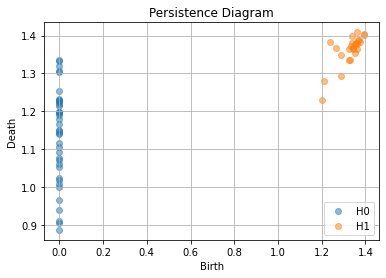

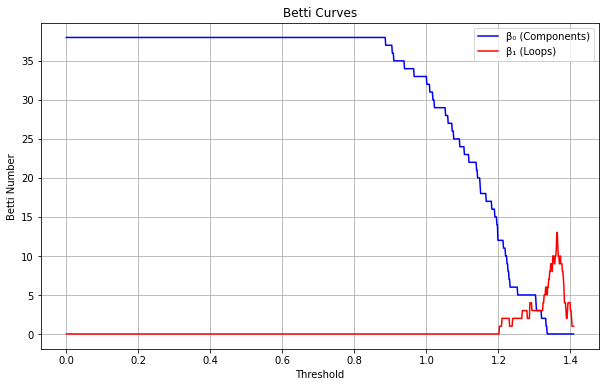

The Betti-1 value 13.0 has a range [1.3622, 1.3636]
The Betti-1 value 11.0 has a range [1.3608, 1.3608]
The Betti-1 value 11.0 has a range [1.3650, 1.3650]
The Betti-1 value 10.0 has a range [1.3509, 1.3537]
The Betti-1 value 10.0 has a range [1.3579, 1.3593]
The Betti-1 value 10.0 has a range [1.3664, 1.3678]
The Betti-1 value 10.0 has a range [1.3720, 1.3720]
The Betti-1 value 9.0 has a range [1.3452, 1.3481]
The Betti-1 value 9.0 has a range [1.3551, 1.3565]
The Betti-1 value 9.0 has a range [1.3692, 1.3706]
The Betti-1 value 9.0 has a range [1.3734, 1.3763]
The Betti-1 value 8.0 has a range [1.3424, 1.3438]
The Betti-1 value 8.0 has a range [1.3495, 1.3495]
The Betti-1 value 8.0 has a range [1.3777, 1.3791]
The Betti-1 value 7.0 has a range [1.3396, 1.3410]
The Betti-1 value 7.0 has a range [1.3805, 1.3805]
The Betti-1 value 6.0 has a range [1.3311, 1.3340]
The Betti-1 value 6.0 has a range [1.3368, 1.3382]
The Betti-1 value 6.0 has a range [1.3819, 1.3819]
The Betti-1 value 5.0 ha

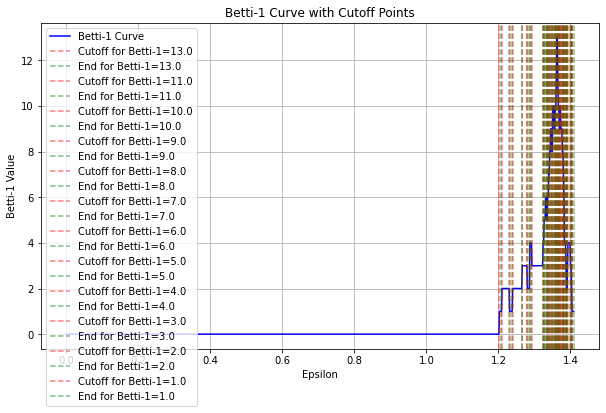

Betti-1 value 13.0 has a total range of 0.0014
Betti-1 value 11.0 has a total range of 0.0000
Betti-1 value 10.0 has a total range of 0.0056
Betti-1 value 9.0 has a total range of 0.0085
Betti-1 value 8.0 has a total range of 0.0028
Betti-1 value 7.0 has a total range of 0.0014
Betti-1 value 6.0 has a total range of 0.0042
Betti-1 value 5.0 has a total range of 0.0028
Betti-1 value 4.0 has a total range of 0.0141
Betti-1 value 3.0 has a total range of 0.0437
Betti-1 value 2.0 has a total range of 0.0522
Betti-1 value 1.0 has a total range of 0.0034

The Betti-1 value with the highest total range is 2.0 with a total range of 0.0522
The mean range for the Betti number with the highest total range is: 1.3065
The corresponding Betti number is: 2.0


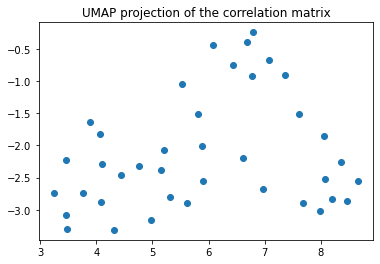

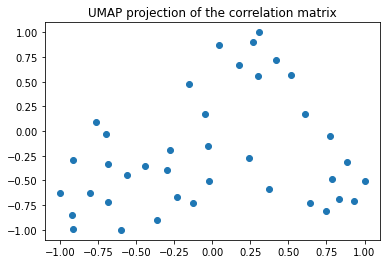

The diameter of the dataset (rounded to the nearest integer) is: 2
For alpha = 10%, N = 16



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


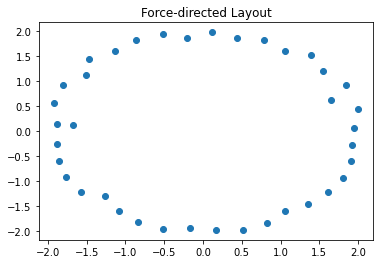

usetex mode requires TeX.


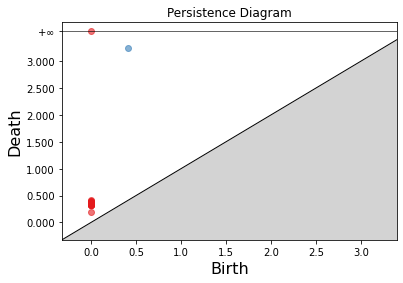

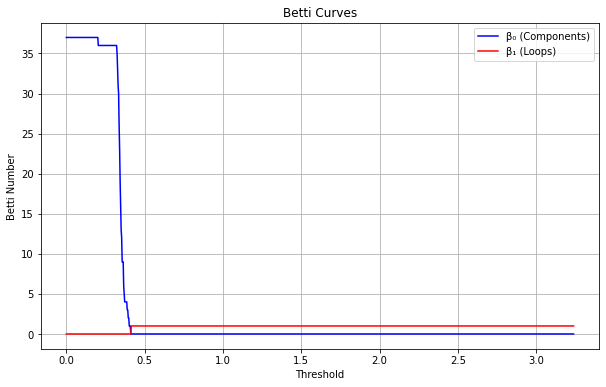

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4148
Betti condition is not satisfied.
For alpha = 15%, N = 17



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


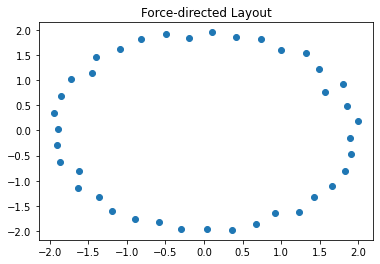

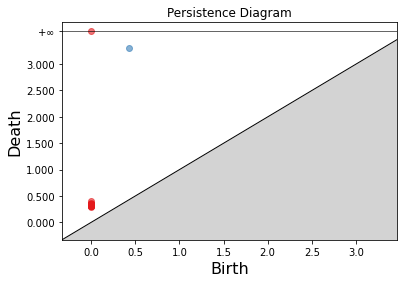

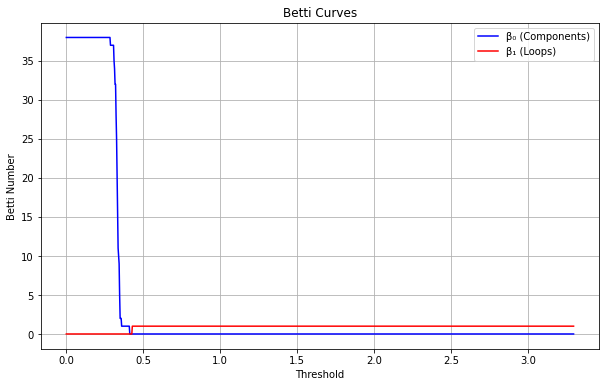

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4289
Betti condition is not satisfied.
For alpha = 20%, N = 18



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


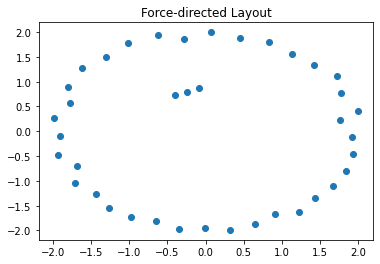

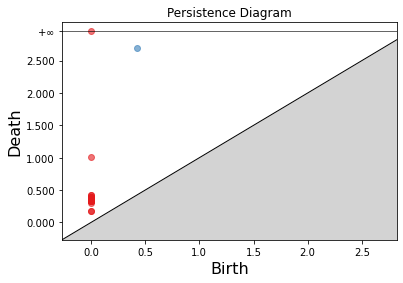

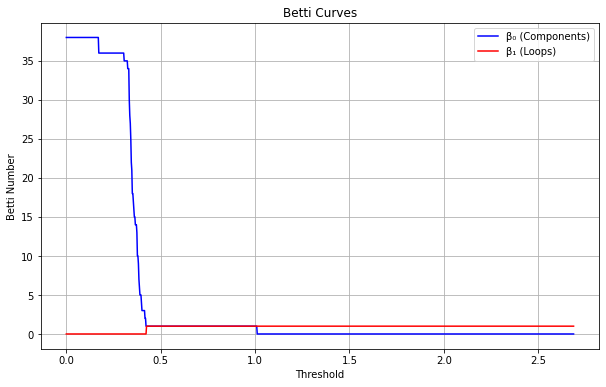

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4251
Betti condition is not satisfied.
For alpha = 25%, N = 20



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


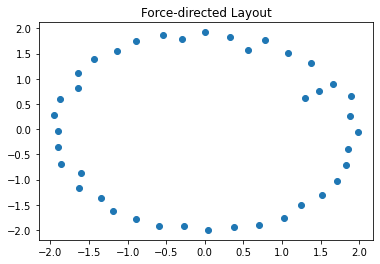

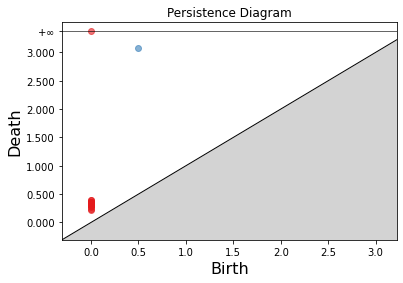

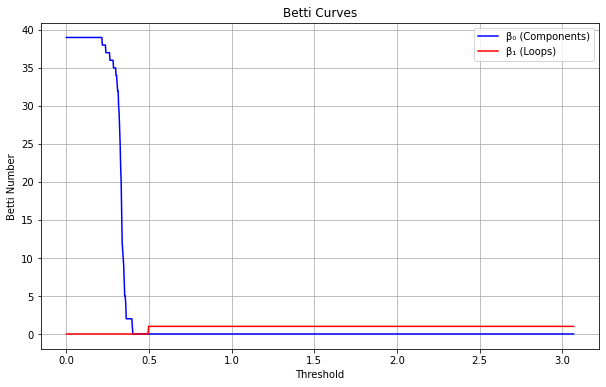

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4977
Betti condition is not satisfied.
For alpha = 30%, N = 21



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


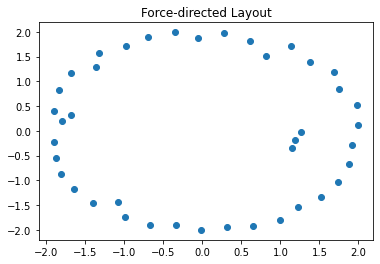

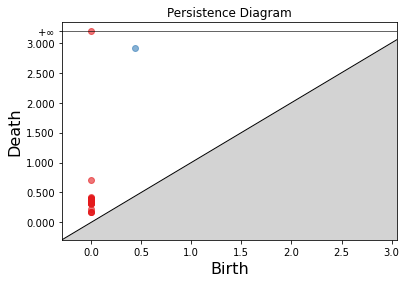

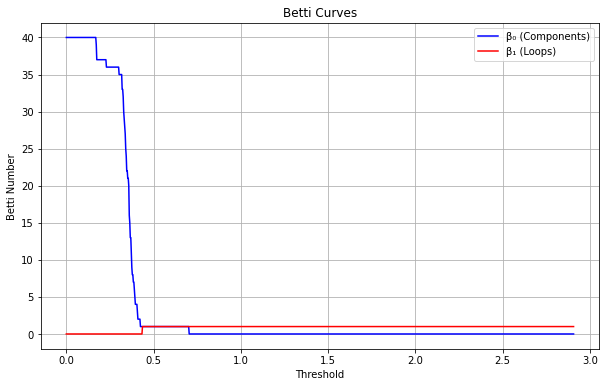

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4363
Betti condition is not satisfied.
For alpha = 35%, N = 23



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


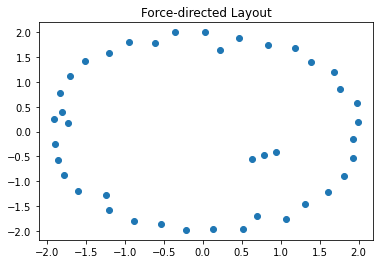

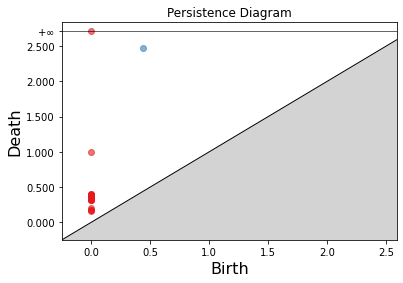

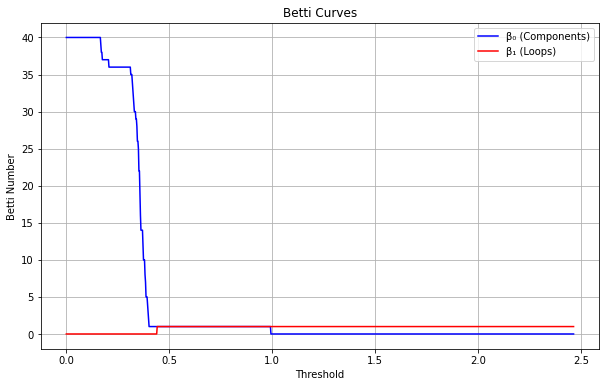

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4416
Betti condition is not satisfied.
For alpha = 40%, N = 24



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


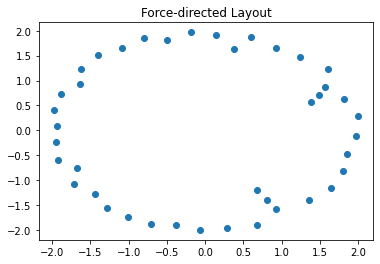

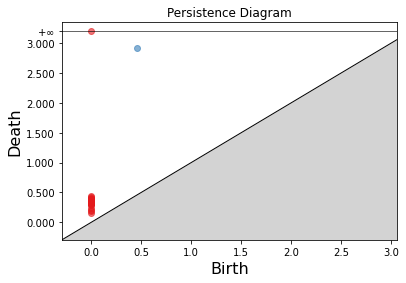

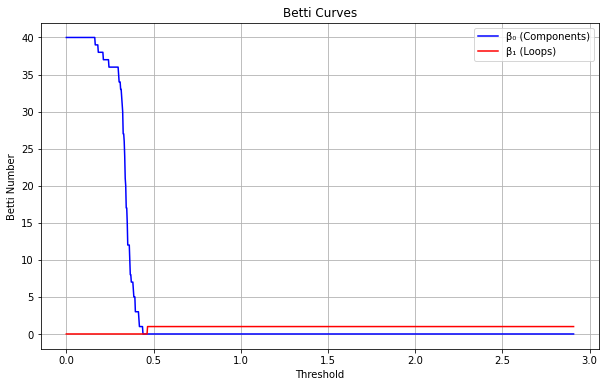

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4657
Betti condition is not satisfied.
For alpha = 45%, N = 27



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


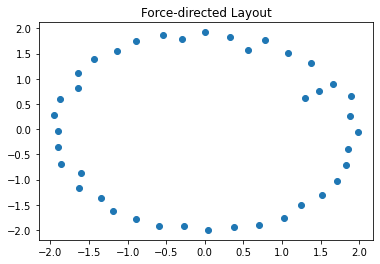

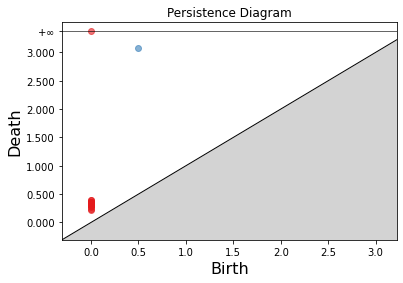

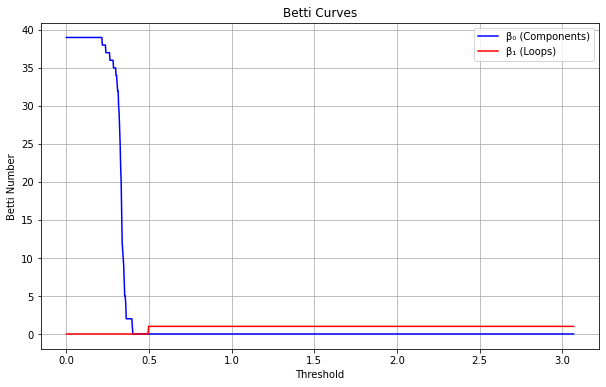

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4977
Betti condition is not satisfied.
For alpha = 50%, N = 29



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


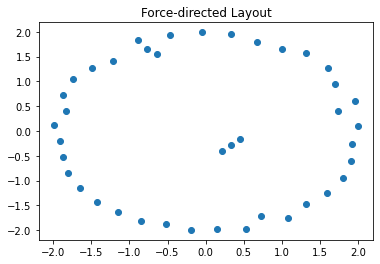

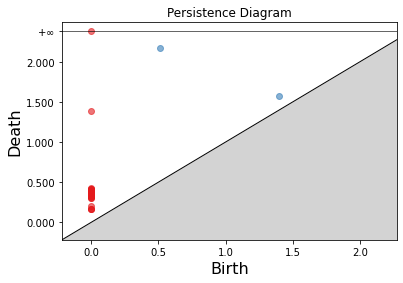

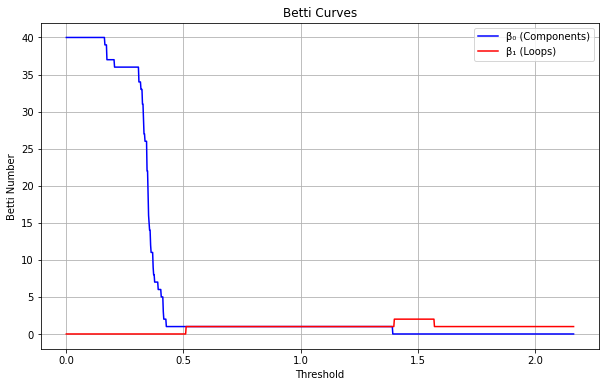

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 1.3997
Betti condition is satisfied.


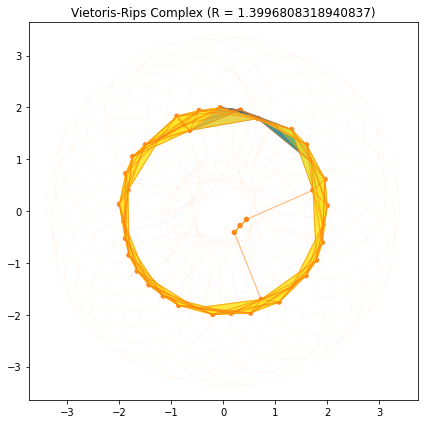

Connected Components: [array([[ 0.33527005,  1.94659336],
       [ 1.69506816,  0.94548664],
       [-1.42286474, -1.42220909],
       [-1.86769481,  0.72463794],
       [-0.77117145,  1.65818223],
       [-0.88658444,  1.82809272],
       [ 1.79558809, -0.94702853],
       [-1.14928632, -1.63707569],
       [-0.64187214,  1.55663235],
       [ 0.73172872, -1.70508047],
       [ 0.32631261, -0.28109157],
       [ 0.21552252, -0.41214485],
       [ 0.66939071,  1.78668588],
       [-1.90633739, -0.20014957],
       [ 0.53027383, -1.96502268],
       [ 1.31894726, -1.46894809],
       [-0.46307798,  1.9356189 ],
       [ 1.60390124,  1.27741562],
       [-0.85104516, -1.81959367],
       [ 1.92172821, -0.2589709 ],
       [-1.87690068, -0.52746367],
       [-1.73591774,  1.04908282],
       [-1.21368149,  1.40497039],
       [ 1.72931537,  0.40329266],
       [ 0.15335239, -1.97090152],
       [ 1.9588062 ,  0.61081065],
       [ 1.3159664 ,  1.57294981],
       [ 0.4485591 , -0.16127123


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


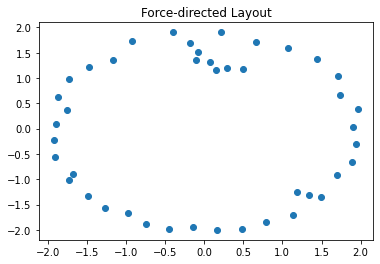

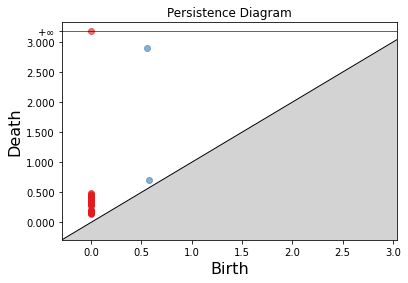

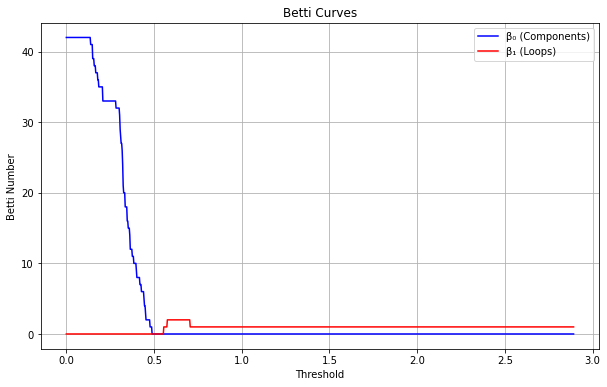

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 0.5761
Betti condition is satisfied.


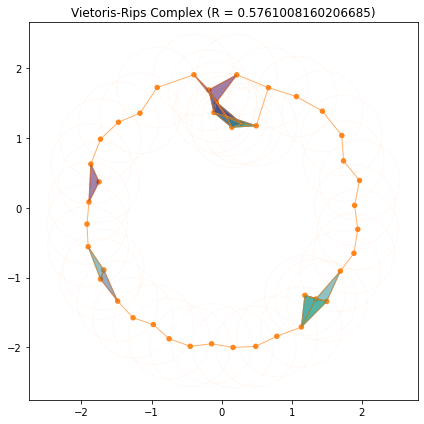

Connected Components: [array([[ 0.21685007,  1.90263272],
       [ 1.73953962,  0.67082671],
       [-1.26351161, -1.57494505],
       [-1.86555611,  0.62496066],
       [-0.07587932,  1.50994573],
       [-0.18236404,  1.68639712],
       [ 1.88846747, -0.65159559],
       [-1.48357822, -1.33592237],
       [ 0.06989106,  1.31302953],
       [-0.1083712 ,  1.36328478],
       [ 0.78751587, -1.83970342],
       [-1.68058743, -0.89071194],
       [ 0.66786248,  1.71909445],
       [-1.89286283,  0.08245767],
       [ 0.48737008, -1.98404275],
       [ 1.69467969, -0.90594817],
       [-0.91863149,  1.72163658],
       [ 1.71555896,  1.03464684],
       [-0.74850231, -1.87558607],
       [ 1.89725664,  0.03418986],
       [-1.92076802, -0.23393895],
       [-1.72821221,  0.98199027],
       [-1.16490879,  1.35382827],
       [ 1.18869851, -1.2531316 ],
       [ 1.34475578, -1.30693521],
       [ 1.96839425,  0.39055556],
       [ 1.43835791,  1.38246619],
       [ 1.06678739,  1.59152055


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


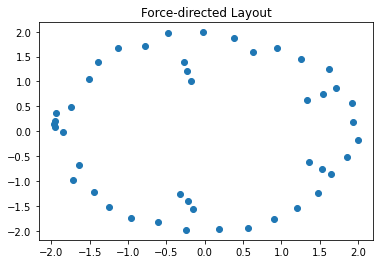

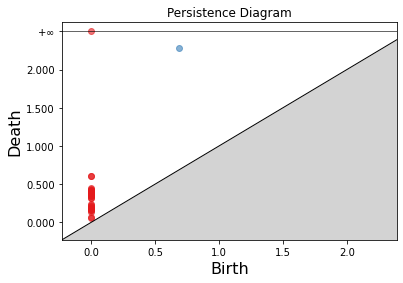

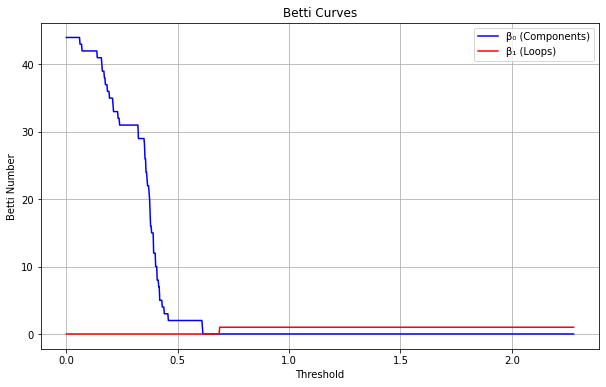

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.6884
Betti condition is not satisfied.

Results DataFrame:
   %overlap  N value  Betti_1_1  Betti_1_2  epsilon_1  epsilon_2
0        50       29        2.0        2.0   1.306469   1.399681
1        55       32        2.0        2.0   1.306469   0.576101


In [2]:
# Example usage
corr_matrix_path = "clinical_corr_2.csv"
k = 0.04  # Example value for k
cutoff_betti = 0.5  # Example cutoff Betti value
results_df_clinical = process_correlation_matrix(corr_matrix_path, k, cutoff_betti)

C:\Users\nasee\anaconda3\lib\site-packages\ripser\ripser.py:247: UserWarning:

The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?



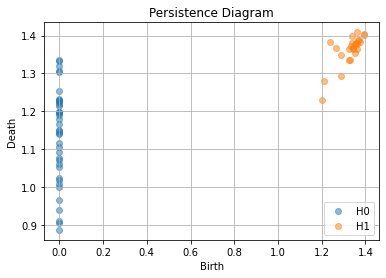

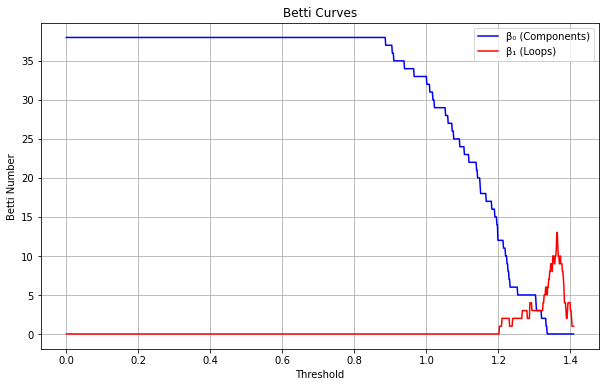

The Betti-1 value 13.0 has a range [1.3622, 1.3636]
The Betti-1 value 11.0 has a range [1.3608, 1.3608]
The Betti-1 value 11.0 has a range [1.3650, 1.3650]
The Betti-1 value 10.0 has a range [1.3509, 1.3537]
The Betti-1 value 10.0 has a range [1.3579, 1.3593]
The Betti-1 value 10.0 has a range [1.3664, 1.3678]
The Betti-1 value 10.0 has a range [1.3720, 1.3720]
The Betti-1 value 9.0 has a range [1.3452, 1.3481]
The Betti-1 value 9.0 has a range [1.3551, 1.3565]
The Betti-1 value 9.0 has a range [1.3692, 1.3706]
The Betti-1 value 9.0 has a range [1.3734, 1.3763]
The Betti-1 value 8.0 has a range [1.3424, 1.3438]
The Betti-1 value 8.0 has a range [1.3495, 1.3495]
The Betti-1 value 8.0 has a range [1.3777, 1.3791]
The Betti-1 value 7.0 has a range [1.3396, 1.3410]
The Betti-1 value 7.0 has a range [1.3805, 1.3805]
The Betti-1 value 6.0 has a range [1.3311, 1.3340]
The Betti-1 value 6.0 has a range [1.3368, 1.3382]
The Betti-1 value 6.0 has a range [1.3819, 1.3819]
The Betti-1 value 5.0 ha

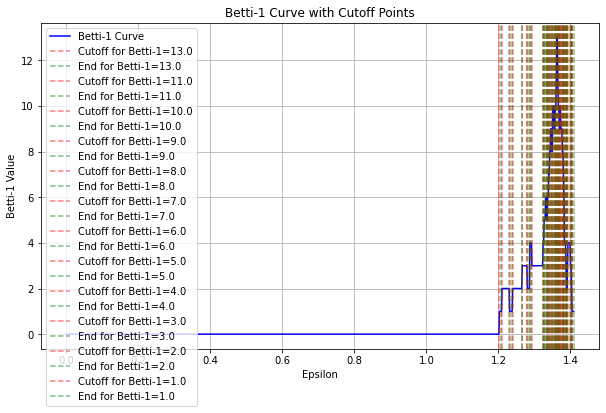

Betti-1 value 13.0 has a total range of 0.0014
Betti-1 value 11.0 has a total range of 0.0000
Betti-1 value 10.0 has a total range of 0.0056
Betti-1 value 9.0 has a total range of 0.0085
Betti-1 value 8.0 has a total range of 0.0028
Betti-1 value 7.0 has a total range of 0.0014
Betti-1 value 6.0 has a total range of 0.0042
Betti-1 value 5.0 has a total range of 0.0028
Betti-1 value 4.0 has a total range of 0.0141
Betti-1 value 3.0 has a total range of 0.0437
Betti-1 value 2.0 has a total range of 0.0522
Betti-1 value 1.0 has a total range of 0.0034

The Betti-1 value with the highest total range is 2.0 with a total range of 0.0522
The mean range for the Betti number with the highest total range is: 1.3065
The corresponding Betti number is: 2.0


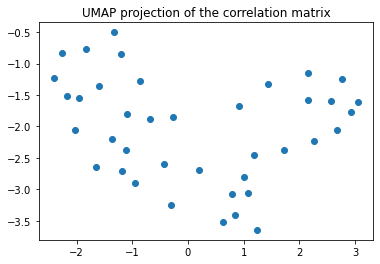

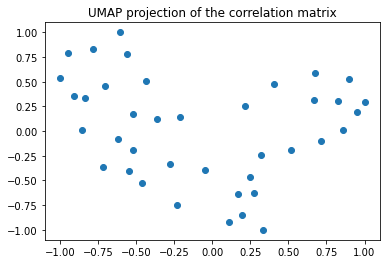

The diameter of the dataset (rounded to the nearest integer) is: 2
For alpha = 10%, N = 16



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


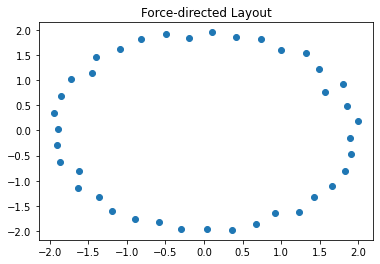

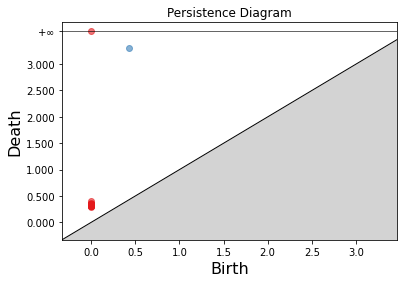

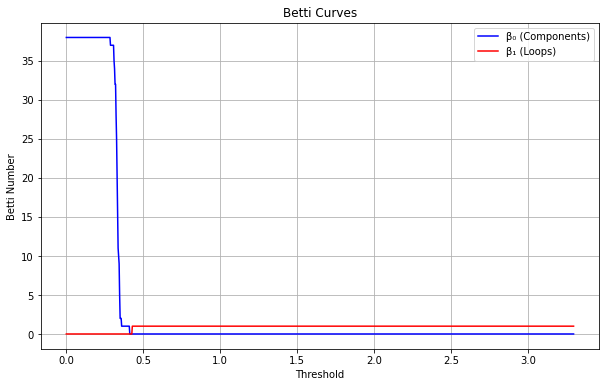

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4289
Betti condition is not satisfied.
For alpha = 15%, N = 17



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


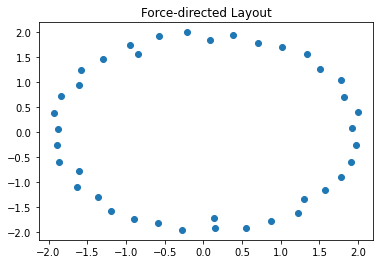

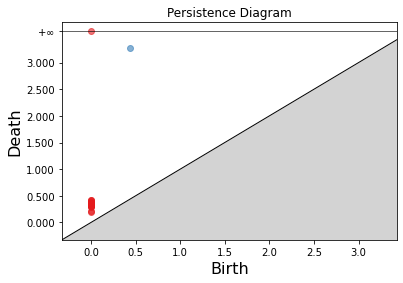

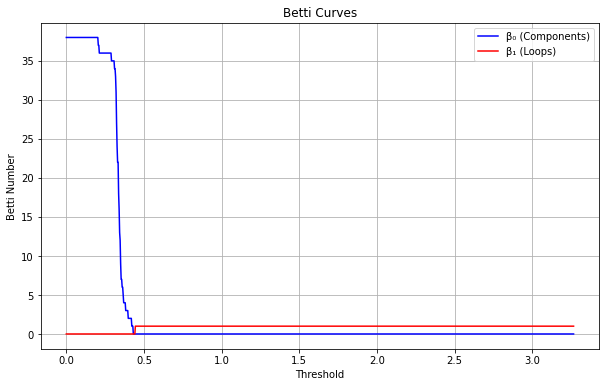

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4446
Betti condition is not satisfied.
For alpha = 20%, N = 18



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


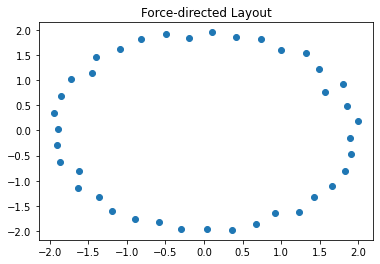

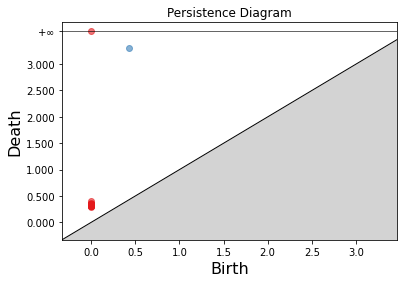

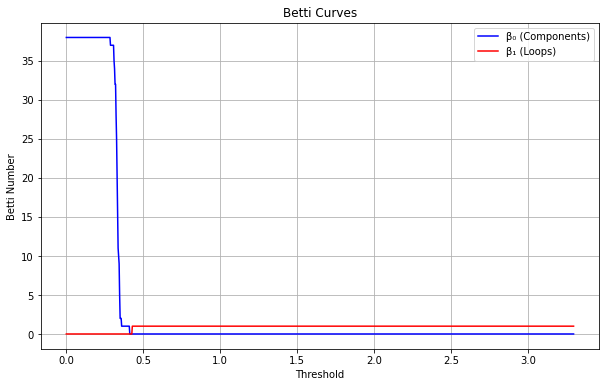

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4289
Betti condition is not satisfied.
For alpha = 25%, N = 20



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


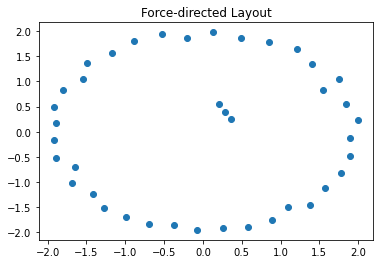

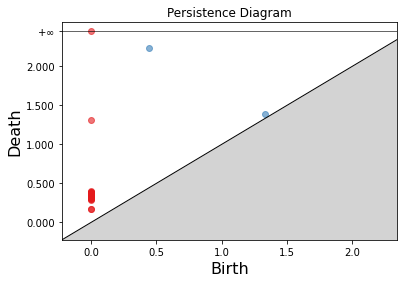

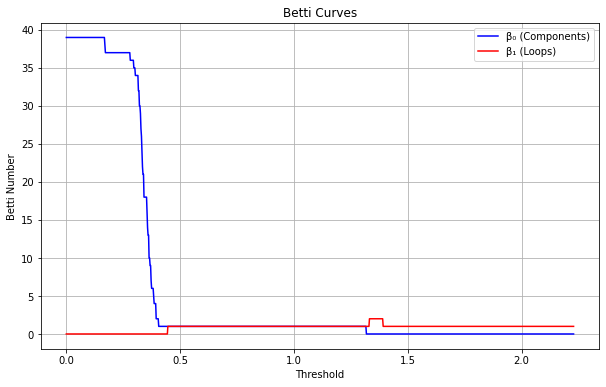

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 1.3318
Betti condition is satisfied.


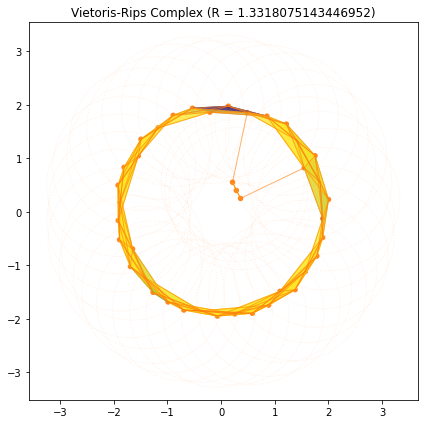

Connected Components: [array([[ 0.13421659,  1.97403408],
       [ 1.84590624,  0.54935808],
       [-1.26843167, -1.50629405],
       [-1.80840471,  0.83133364],
       [ 0.28242346,  0.39818139],
       [ 0.21178181,  0.55242587],
       [ 0.36183906,  0.24979829],
       [-0.98857214, -1.68609259],
       [-1.65015643, -0.69537564],
       [ 1.09837295, -1.48656924],
       [ 0.88568768, -1.74480854],
       [-1.41981123, -1.22962956],
       [ 0.48651209,  1.85448492],
       [-1.88745926,  0.17151805],
       [ 0.58177528, -1.89649534],
       [ 1.57005483, -1.1133526 ],
       [-0.89299032,  1.80302839],
       [ 1.74881574,  1.04836931],
       [-0.69470304, -1.83611882],
       [ 1.89434804, -0.12748903],
       [-1.91735011, -0.16241247],
       [-1.49302507,  1.35612053],
       [-0.21062952,  1.86253402],
       [ 1.54732131,  0.82289977],
       [ 0.25454167, -1.90948266],
       [ 2.        ,  0.22998504],
       [ 1.2160651 ,  1.63851564],
       [ 0.85145406,  1.78793671


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


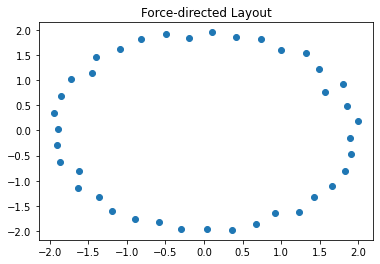

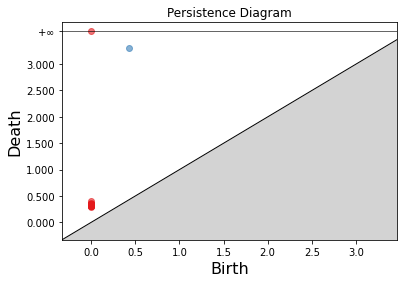

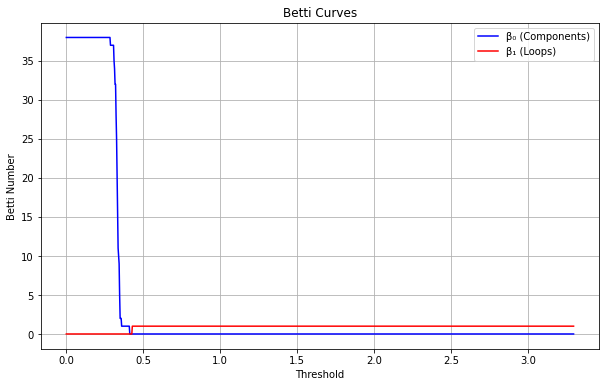

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4289
Betti condition is not satisfied.
For alpha = 35%, N = 23



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


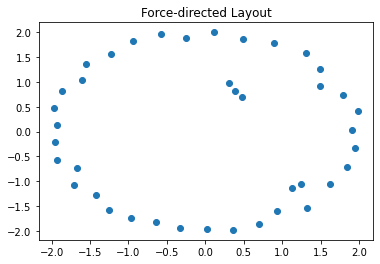

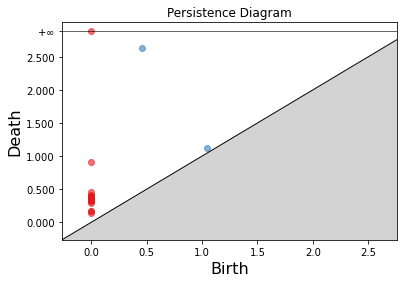

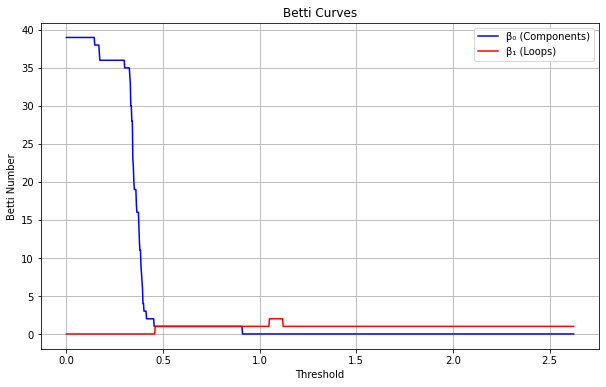

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 1.0507
Betti condition is satisfied.


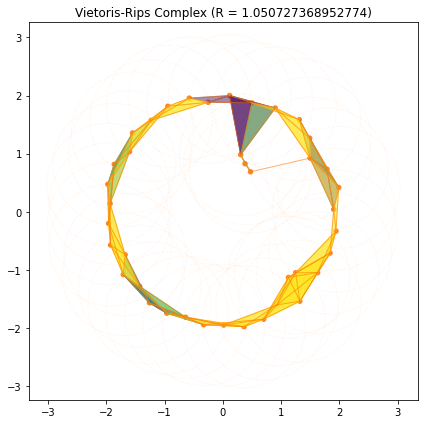

Connected Components: [array([[ 0.11733363,  2.        ],
       [ 1.7879106 ,  0.73282952],
       [-1.25885098, -1.56895984],
       [-1.86219635,  0.81543112],
       [ 0.38223474,  0.82592934],
       [ 0.30754111,  0.98169253],
       [ 0.47624284,  0.68646819],
       [-0.96118203, -1.74619943],
       [-1.67590568, -0.74058923],
       [ 0.93198467, -1.60397613],
       [ 0.7021814 , -1.85013121],
       [-1.42525202, -1.28587459],
       [ 0.49673989,  1.87328613],
       [-1.93398616,  0.14053497],
       [ 0.36570401, -1.97891795],
       [ 1.62863489, -1.046838  ],
       [-0.94314067,  1.8155554 ],
       [ 1.2499083 , -1.05139751],
       [ 1.12741049, -1.13137344],
       [ 1.90393542,  0.03996482],
       [-1.95890477, -0.20129685],
       [-1.54801324,  1.35584125],
       [-0.25109282,  1.88455029],
       [ 1.49810544,  0.92382311],
       [ 0.01559333, -1.95169965],
       [ 1.98934612,  0.41696352],
       [ 1.31292825,  1.58452254],
       [ 0.89967269,  1.78463424


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


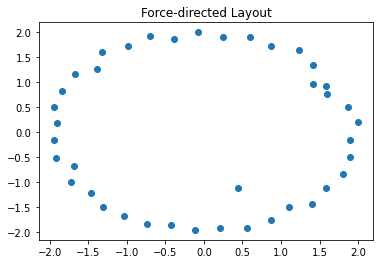

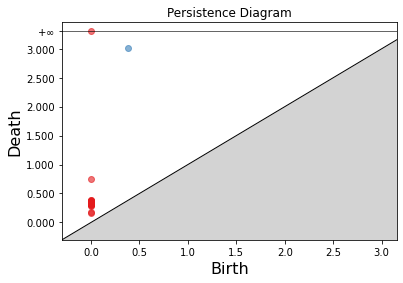

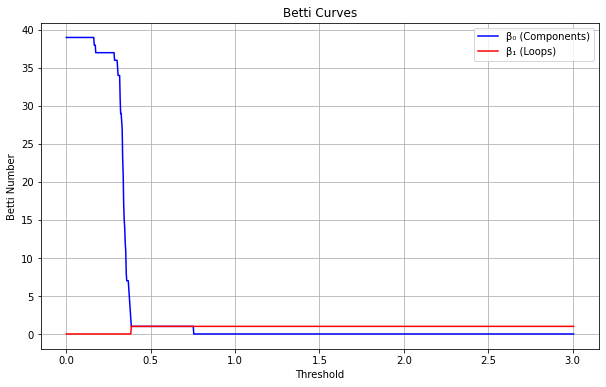

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.3851
Betti condition is not satisfied.
For alpha = 45%, N = 27



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


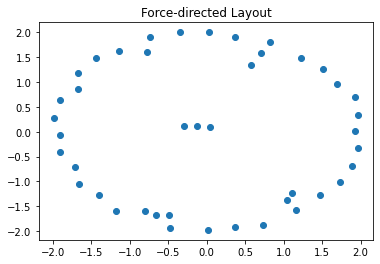

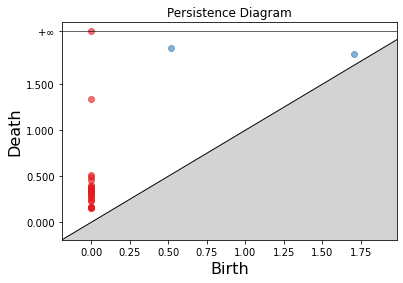

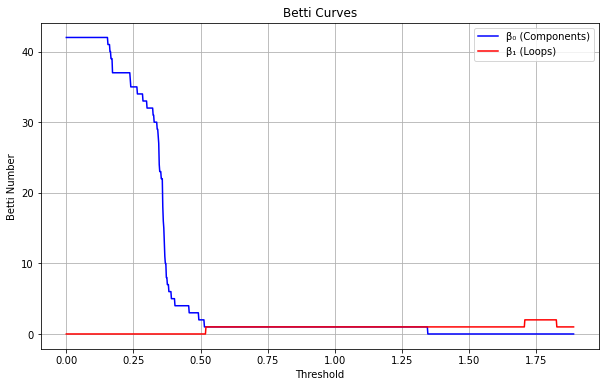

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 1.7066
Betti condition is satisfied.


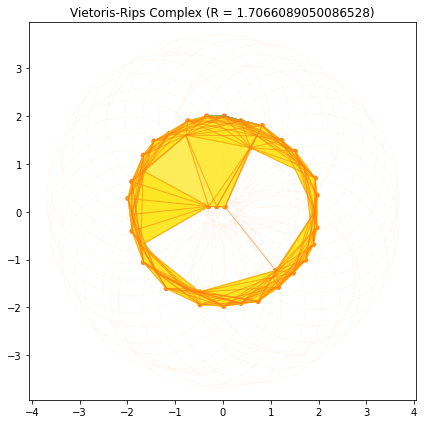

Connected Components: [array([[ 0.03000982,  1.9986087 ],
       [ 1.69413212,  0.95096149],
       [-1.18425604, -1.60244458],
       [-1.90504745,  0.62882752],
       [ 1.22793994,  1.48612075],
       [-1.44341162,  1.47547391],
       [ 1.89316485, -0.68431521],
       [-1.6620491 , -1.05815665],
       [-0.77544528,  1.6013245 ],
       [-0.65475917, -1.6666447 ],
       [-0.48911985, -1.67975756],
       [-1.71619592, -0.70022893],
       [ 0.37344586,  1.89789458],
       [-1.91004264, -0.0566392 ],
       [ 0.73456847, -1.87310953],
       [ 1.46838753, -1.28166459],
       [-0.73268536,  1.89733642],
       [ 1.1054144 , -1.22982718],
       [ 1.04372459, -1.37018819],
       [ 1.92793235,  0.00911658],
       [-1.90162266, -0.40826856],
       [-1.66622238,  1.17840814],
       [ 0.04223439,  0.10317691],
       [-0.12958909,  0.10852956],
       [ 0.37357953, -1.91381137],
       [ 1.92719493,  0.7011302 ],
       [ 0.70756303,  1.588276  ],
       [ 0.82014543,  1.79824217


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


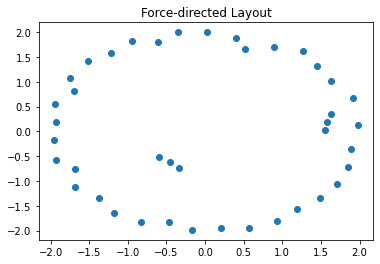

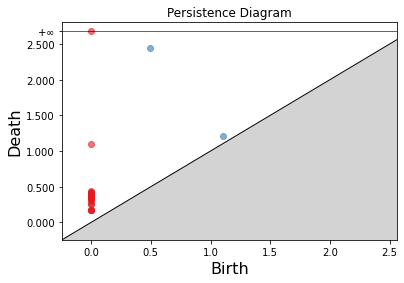

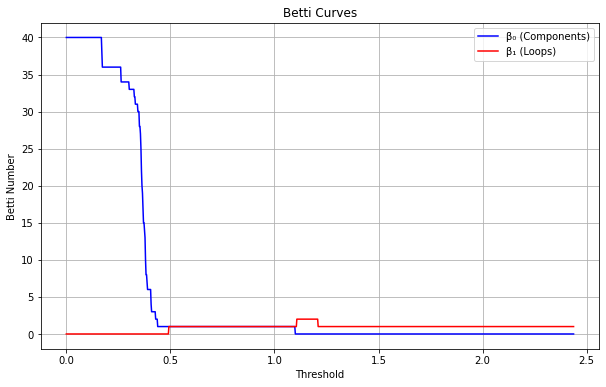

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 1.1076
Betti condition is satisfied.


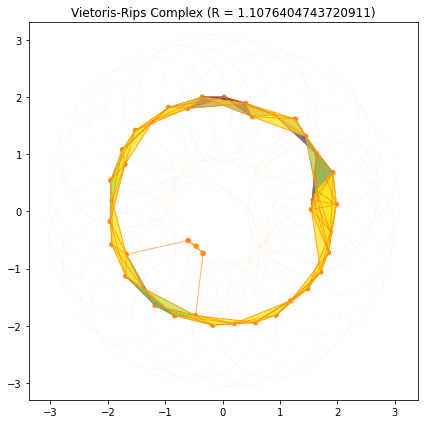

Connected Components: [array([[ 0.0260491 ,  1.99857761],
       [ 1.63299763,  1.00945047],
       [-1.17619305, -1.64212152],
       [-1.94920614,  0.54484979],
       [ 0.89433982,  1.69642939],
       [-1.52007297,  1.41758545],
       [ 1.70878802, -1.05694412],
       [-0.83302765, -1.82027128],
       [-1.67985566, -0.74881611],
       [ 1.58011384,  0.19896242],
       [ 1.54693116,  0.03282175],
       [-1.38019534, -1.34592933],
       [ 0.40051914,  1.88957875],
       [-1.92478399,  0.18905247],
       [ 0.57124203, -1.94039767],
       [ 1.18721324, -1.56097082],
       [-0.94293432,  1.81843438],
       [-0.34025459, -0.73002079],
       [-0.46083263, -0.60719165],
       [ 1.88314593, -0.35524506],
       [-1.95926123, -0.17435134],
       [-1.74627865,  1.08011368],
       [-0.61387317,  1.80263751],
       [ 0.51981219,  1.65673743],
       [ 0.2055516 , -1.95631724],
       [ 1.92056802,  0.67811509],
       [ 1.26584172,  1.61512196],
       [ 1.63143522,  0.36073331


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


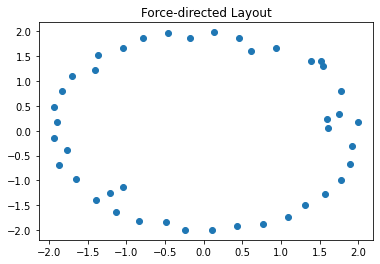

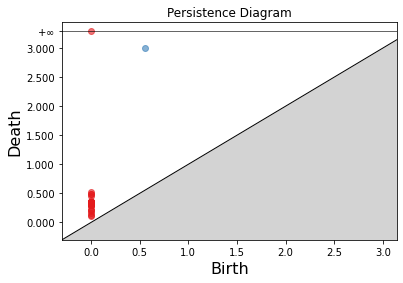

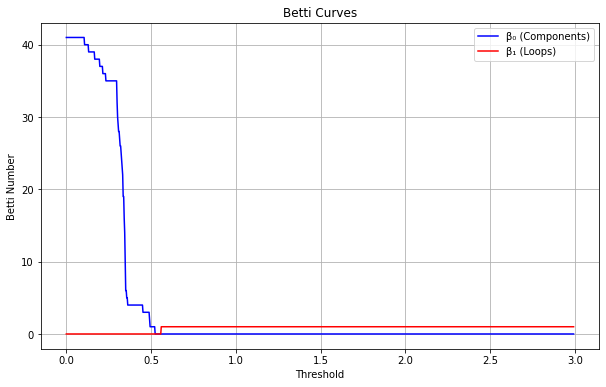

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.5602
Betti condition is not satisfied.
For alpha = 60%, N = 36



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


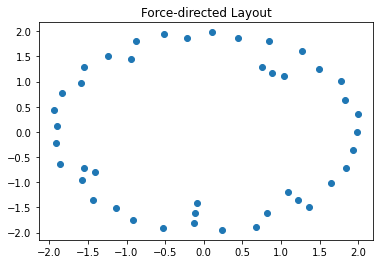

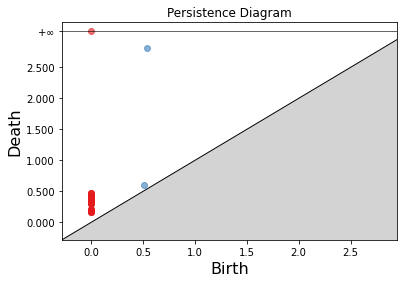

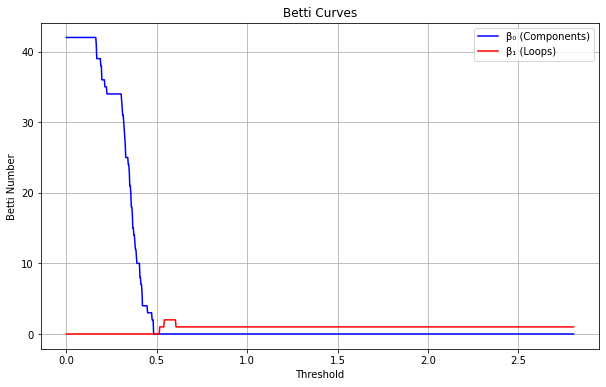

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 0.5419
Betti condition is satisfied.


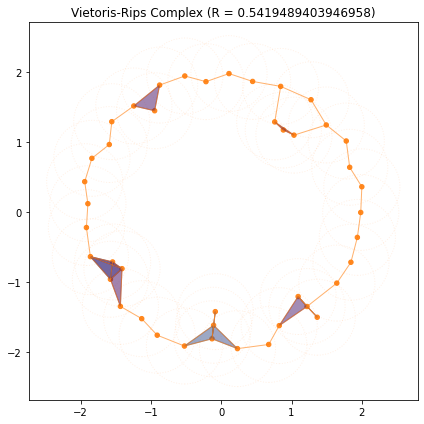

Connected Components: [array([[ 0.11009638,  1.97941906],
       [ 1.82730903,  0.64198761],
       [-0.91099405, -1.75427113],
       [-1.84031276,  0.76998324],
       [ 0.88326037,  1.17469538],
       [ 0.76081837,  1.28967273],
       [ 1.03463775,  1.10099238],
       [-1.43479536, -1.34277655],
       [-0.94772091,  1.44880648],
       [ 0.82480096, -1.6175684 ],
       [-1.41177785, -0.80481023],
       [-1.54591825, -0.70913502],
       [ 0.44629956,  1.86733147],
       [-1.8972483 ,  0.12242321],
       [ 0.67518883, -1.8866676 ],
       [ 1.64392155, -1.01099562],
       [-0.87697699,  1.81518841],
       [ 1.77825752,  1.01722956],
       [ 1.0935362 , -1.20282038],
       [ 1.22012687, -1.34477449],
       [-1.91835199, -0.21796884],
       [-1.55710425,  1.29303743],
       [-0.21751343,  1.86429178],
       [-0.08497422, -1.41817404],
       [-0.10919022, -1.61252534],
       [ 2.        ,  0.36377603],
       [ 1.27722104,  1.60630812],
       [ 0.84545685,  1.79664829

In [3]:
# Example usage
corr_matrix_path = "clinical_corr_2.csv"
k = 0.03  # Example value for k
cutoff_betti = 0.5  # Example cutoff Betti value
results_df_clinical = process_correlation_matrix(corr_matrix_path, k, cutoff_betti)

C:\Users\nasee\anaconda3\lib\site-packages\ripser\ripser.py:247: UserWarning:

The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?



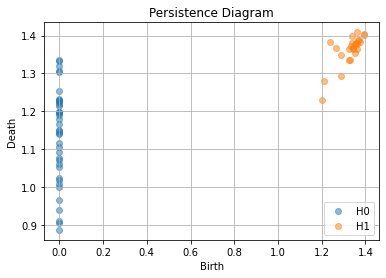

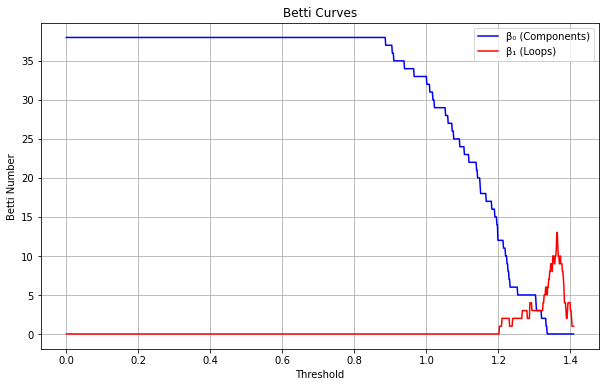

The Betti-1 value 13.0 has a range [1.3622, 1.3636]
The Betti-1 value 11.0 has a range [1.3608, 1.3608]
The Betti-1 value 11.0 has a range [1.3650, 1.3650]
The Betti-1 value 10.0 has a range [1.3509, 1.3537]
The Betti-1 value 10.0 has a range [1.3579, 1.3593]
The Betti-1 value 10.0 has a range [1.3664, 1.3678]
The Betti-1 value 10.0 has a range [1.3720, 1.3720]
The Betti-1 value 9.0 has a range [1.3452, 1.3481]
The Betti-1 value 9.0 has a range [1.3551, 1.3565]
The Betti-1 value 9.0 has a range [1.3692, 1.3706]
The Betti-1 value 9.0 has a range [1.3734, 1.3763]
The Betti-1 value 8.0 has a range [1.3424, 1.3438]
The Betti-1 value 8.0 has a range [1.3495, 1.3495]
The Betti-1 value 8.0 has a range [1.3777, 1.3791]
The Betti-1 value 7.0 has a range [1.3396, 1.3410]
The Betti-1 value 7.0 has a range [1.3805, 1.3805]
The Betti-1 value 6.0 has a range [1.3311, 1.3340]
The Betti-1 value 6.0 has a range [1.3368, 1.3382]
The Betti-1 value 6.0 has a range [1.3819, 1.3819]
The Betti-1 value 5.0 ha

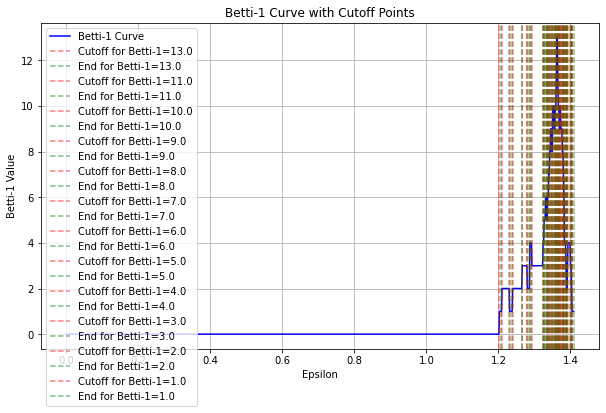

Betti-1 value 13.0 has a total range of 0.0014
Betti-1 value 11.0 has a total range of 0.0000
Betti-1 value 10.0 has a total range of 0.0056
Betti-1 value 9.0 has a total range of 0.0085
Betti-1 value 8.0 has a total range of 0.0028
Betti-1 value 7.0 has a total range of 0.0014
Betti-1 value 6.0 has a total range of 0.0042
Betti-1 value 5.0 has a total range of 0.0028
Betti-1 value 4.0 has a total range of 0.0141
Betti-1 value 3.0 has a total range of 0.0437
Betti-1 value 2.0 has a total range of 0.0522
Betti-1 value 1.0 has a total range of 0.0034

The Betti-1 value with the highest total range is 2.0 with a total range of 0.0522
The mean range for the Betti number with the highest total range is: 1.3065
The corresponding Betti number is: 2.0


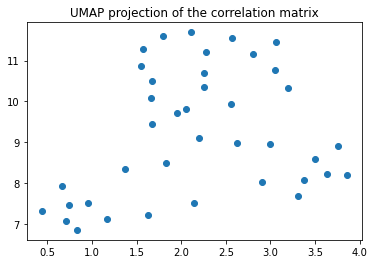

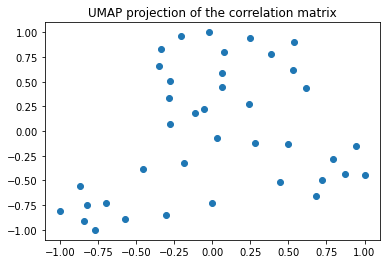

The diameter of the dataset (rounded to the nearest integer) is: 2
For alpha = 10%, N = 16



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


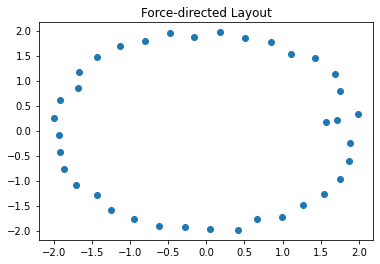

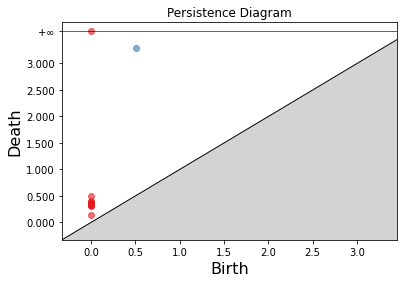

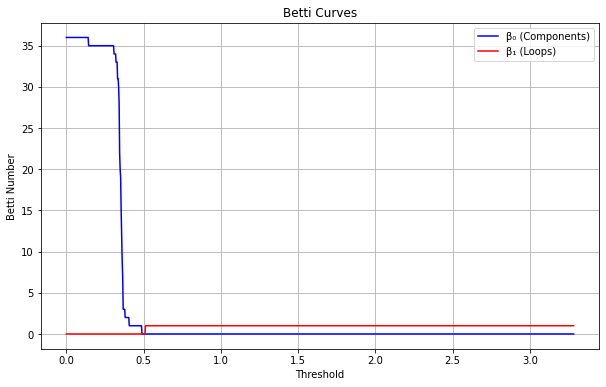

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.5127
Betti condition is not satisfied.
For alpha = 15%, N = 17



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


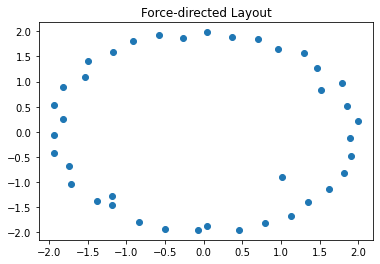

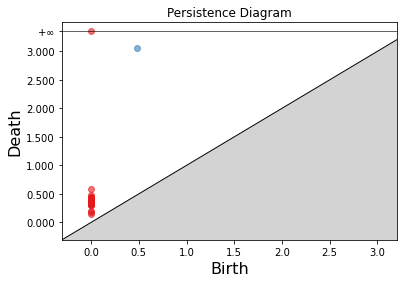

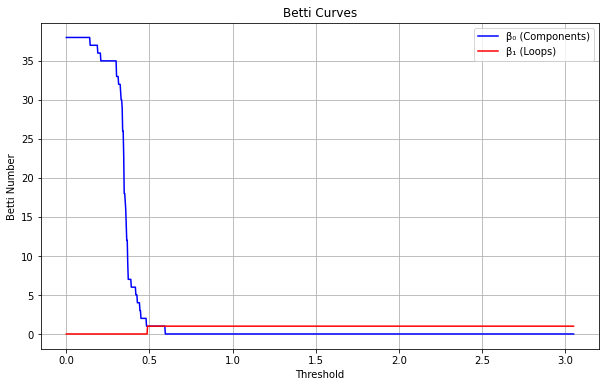

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4885
Betti condition is not satisfied.
For alpha = 20%, N = 18



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


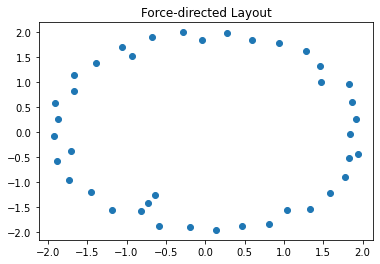

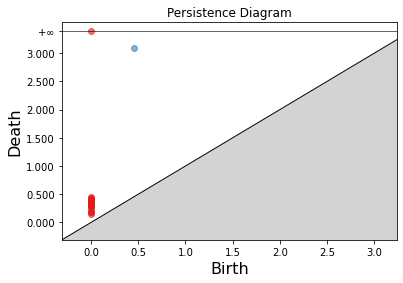

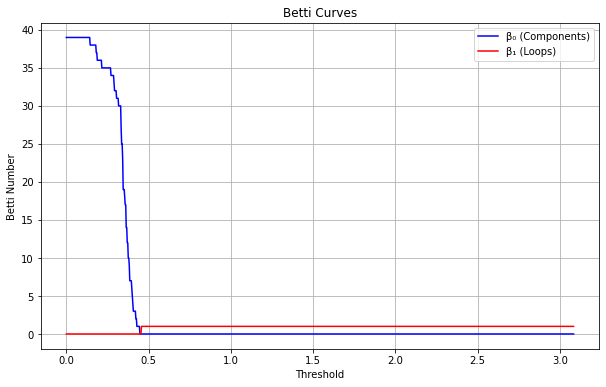

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4568
Betti condition is not satisfied.
For alpha = 25%, N = 20



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


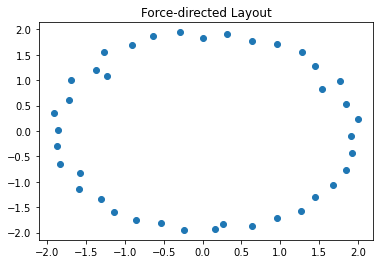

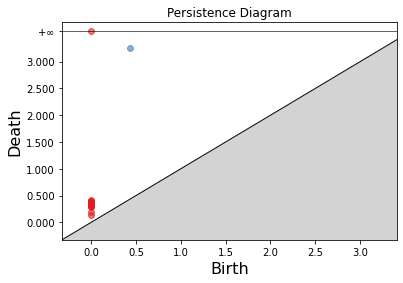

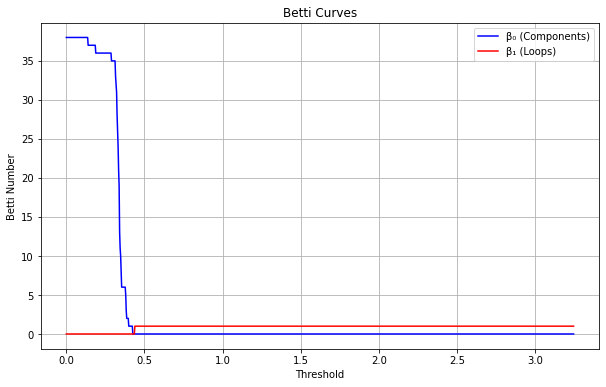

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4386
Betti condition is not satisfied.
For alpha = 30%, N = 21



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


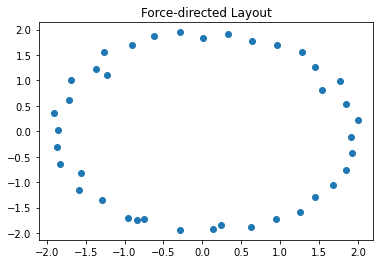

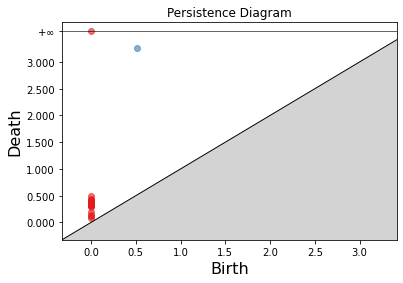

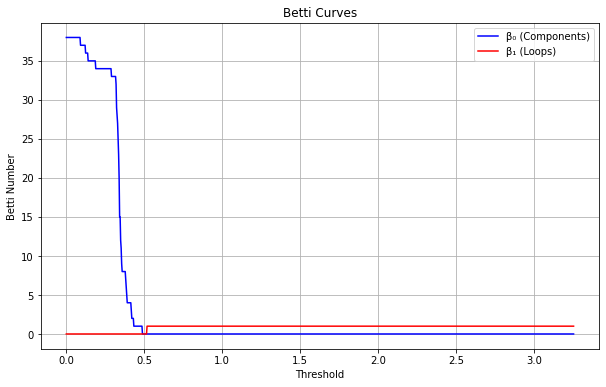

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.5178
Betti condition is not satisfied.
For alpha = 35%, N = 23



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


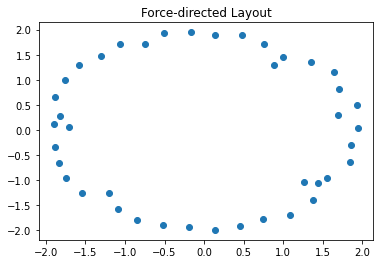

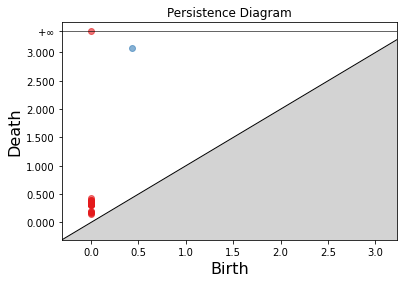

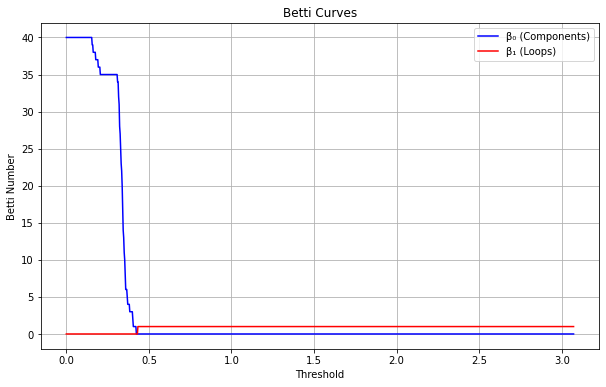

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4335
Betti condition is not satisfied.
For alpha = 40%, N = 24



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


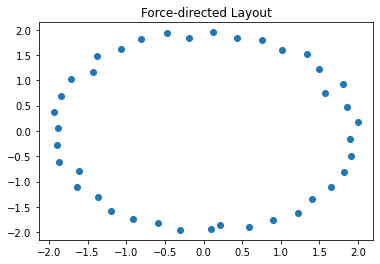

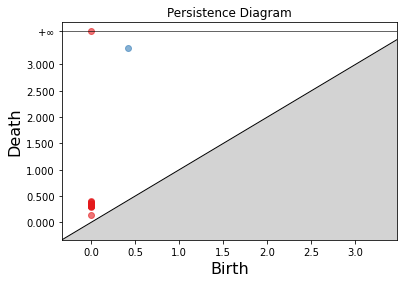

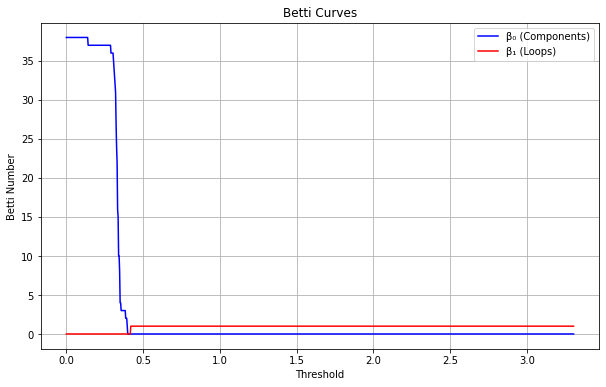

The epsilon (threshold) at which Betti-1 reaches its maximum value of 1.0 is approximately 0.4200
Betti condition is not satisfied.
For alpha = 45%, N = 27



Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


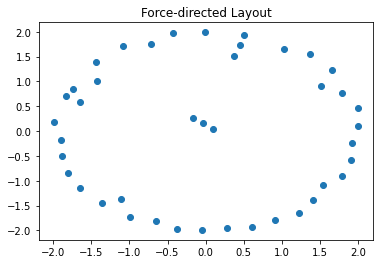

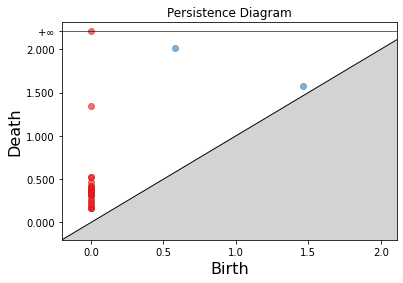

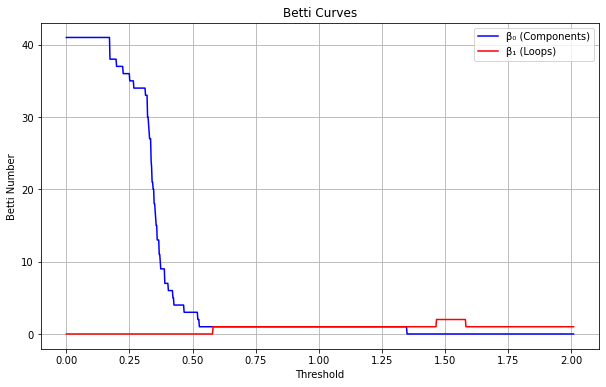

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 1.4667
Betti condition is satisfied.


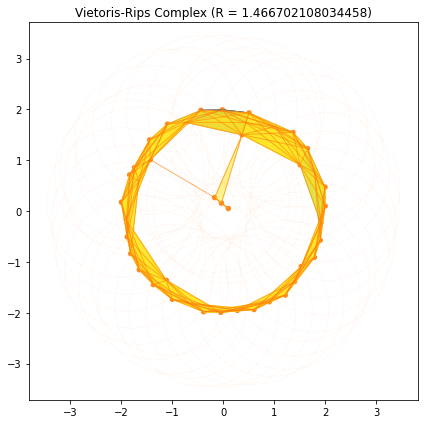

Connected Components: [array([[-0.0133872 ,  1.99047921],
       [ 1.79274749,  0.7603176 ],
       [-1.65315101,  0.57865898],
       [-1.83149602,  0.71314945],
       [-0.03230108,  0.15787047],
       [-0.16564024,  0.26602596],
       [ 0.10171957,  0.05126624],
       [-1.36629014, -1.44578073],
       [-1.11285363, -1.36137341],
       [ 1.5334876 , -1.08912392],
       [ 0.90460708, -1.78297899],
       [ 0.37201242,  1.50265077],
       [ 0.44482348,  1.74307415],
       [-1.89704598, -0.17111923],
       [ 0.60579821, -1.93566284],
       [ 1.40280224, -1.38262991],
       [-1.08949618,  1.70982722],
       [ 1.6538875 ,  1.2303459 ],
       [-0.99477569, -1.73321565],
       [ 1.91677567, -0.23292537],
       [-1.87877314, -0.50499742],
       [-1.43748302,  1.40060208],
       [-0.72372227,  1.7460443 ],
       [ 1.5099611 ,  0.91071159],
       [ 0.27988215, -1.95074701],
       [ 1.99733815,  0.47232788],
       [ 1.36905672,  1.54666186],
       [ 0.50661812,  1.93055399


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


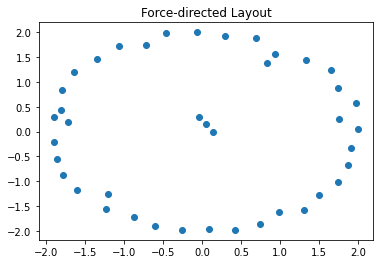

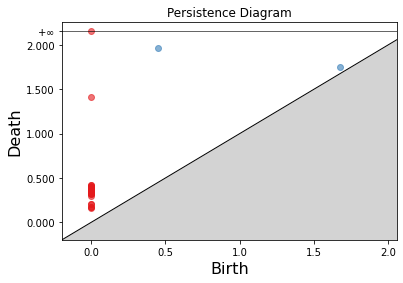

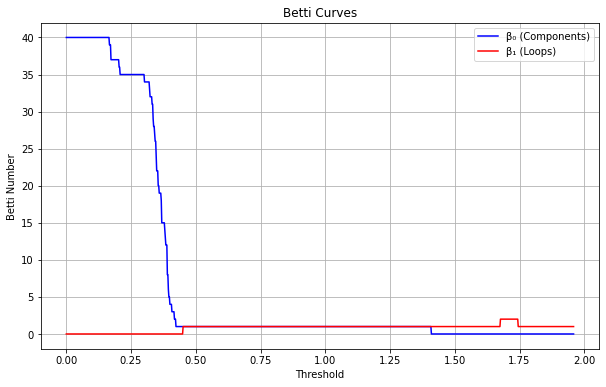

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 1.6763
Betti condition is satisfied.


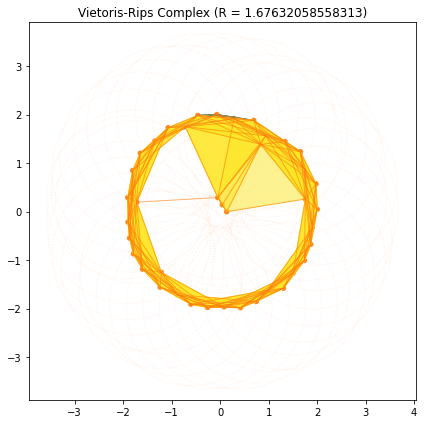

Connected Components: [array([[-0.0688372 ,  1.99943368],
       [ 1.74301695,  0.87698859],
       [-1.71975241,  0.19517673],
       [-1.90353577,  0.28952029],
       [ 0.04377284,  0.14338835],
       [-0.04712318,  0.28989903],
       [ 0.13474879, -0.00232858],
       [-1.23810686, -1.55465229],
       [-1.21277843, -1.25498516],
       [ 0.98526026, -1.61652525],
       [ 0.74459552, -1.84982765],
       [ 0.83540794,  1.387842  ],
       [ 0.28876622,  1.91687539],
       [-1.89946651, -0.21683888],
       [ 0.42101567, -1.9782047 ],
       [ 1.50096543, -1.26955196],
       [-1.07255207,  1.72763975],
       [ 1.65552936,  1.23330203],
       [-0.60272466, -1.90743955],
       [ 1.90194626, -0.3295976 ],
       [-1.86678341, -0.54557955],
       [-1.64644847,  1.20304882],
       [-0.71918724,  1.75034677],
       [ 1.75782703,  0.25994081],
       [ 0.08108307, -1.9602415 ],
       [ 1.97489039,  0.57115132],
       [ 0.93767258,  1.56303262],
       [ 0.6930198 ,  1.87861741


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


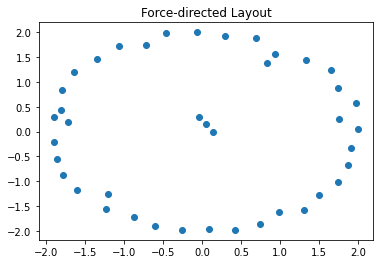

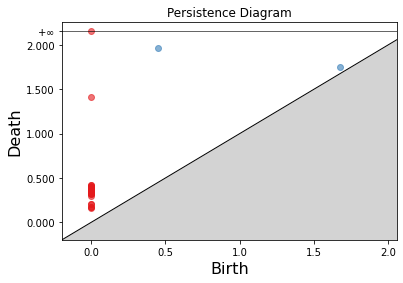

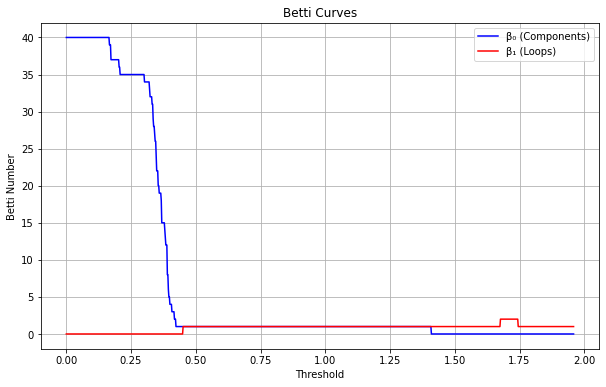

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 1.6763
Betti condition is satisfied.


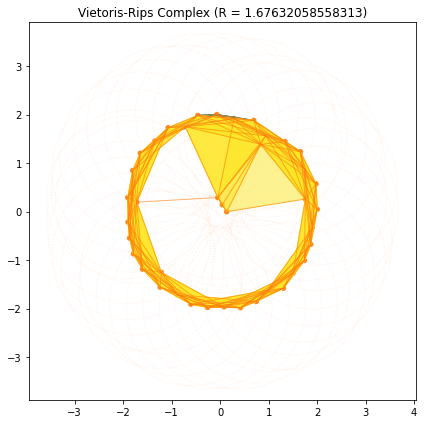

Connected Components: [array([[-0.0688372 ,  1.99943368],
       [ 1.74301695,  0.87698859],
       [-1.71975241,  0.19517673],
       [-1.90353577,  0.28952029],
       [ 0.04377284,  0.14338835],
       [-0.04712318,  0.28989903],
       [ 0.13474879, -0.00232858],
       [-1.23810686, -1.55465229],
       [-1.21277843, -1.25498516],
       [ 0.98526026, -1.61652525],
       [ 0.74459552, -1.84982765],
       [ 0.83540794,  1.387842  ],
       [ 0.28876622,  1.91687539],
       [-1.89946651, -0.21683888],
       [ 0.42101567, -1.9782047 ],
       [ 1.50096543, -1.26955196],
       [-1.07255207,  1.72763975],
       [ 1.65552936,  1.23330203],
       [-0.60272466, -1.90743955],
       [ 1.90194626, -0.3295976 ],
       [-1.86678341, -0.54557955],
       [-1.64644847,  1.20304882],
       [-0.71918724,  1.75034677],
       [ 1.75782703,  0.25994081],
       [ 0.08108307, -1.9602415 ],
       [ 1.97489039,  0.57115132],
       [ 0.93767258,  1.56303262],
       [ 0.6930198 ,  1.87861741


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


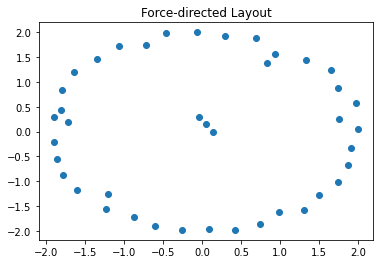

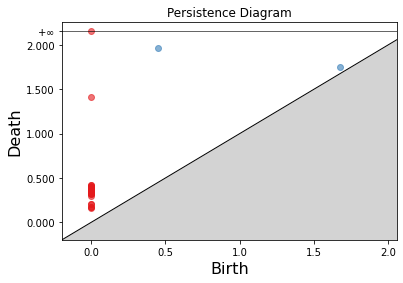

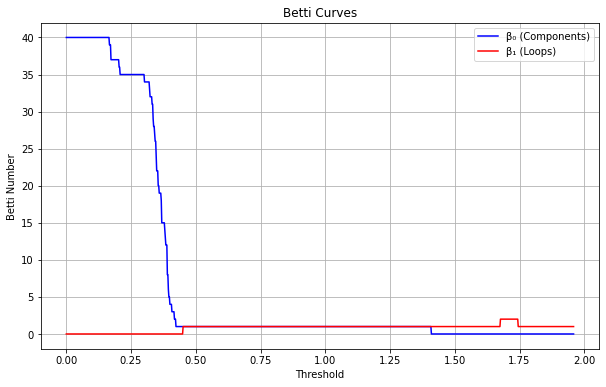

The epsilon (threshold) at which Betti-1 reaches its maximum value of 2.0 is approximately 1.6763
Betti condition is satisfied.


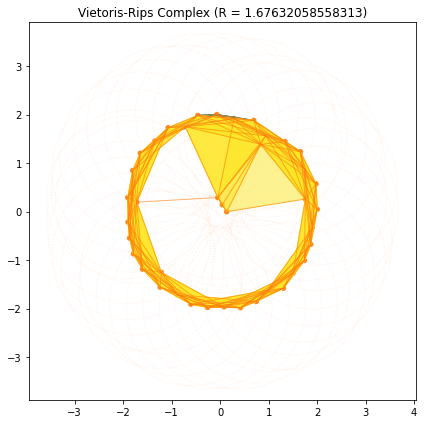

Connected Components: [array([[-0.0688372 ,  1.99943368],
       [ 1.74301695,  0.87698859],
       [-1.71975241,  0.19517673],
       [-1.90353577,  0.28952029],
       [ 0.04377284,  0.14338835],
       [-0.04712318,  0.28989903],
       [ 0.13474879, -0.00232858],
       [-1.23810686, -1.55465229],
       [-1.21277843, -1.25498516],
       [ 0.98526026, -1.61652525],
       [ 0.74459552, -1.84982765],
       [ 0.83540794,  1.387842  ],
       [ 0.28876622,  1.91687539],
       [-1.89946651, -0.21683888],
       [ 0.42101567, -1.9782047 ],
       [ 1.50096543, -1.26955196],
       [-1.07255207,  1.72763975],
       [ 1.65552936,  1.23330203],
       [-0.60272466, -1.90743955],
       [ 1.90194626, -0.3295976 ],
       [-1.86678341, -0.54557955],
       [-1.64644847,  1.20304882],
       [-0.71918724,  1.75034677],
       [ 1.75782703,  0.25994081],
       [ 0.08108307, -1.9602415 ],
       [ 1.97489039,  0.57115132],
       [ 0.93767258,  1.56303262],
       [ 0.6930198 ,  1.87861741

In [4]:
# Example usage
corr_matrix_path = "clinical_corr_2.csv"
k = 0.02  # Example value for k
cutoff_betti = 0.5  # Example cutoff Betti value
results_df_clinical = process_correlation_matrix(corr_matrix_path, k, cutoff_betti)